# Why GRPO Loss is negative and ascend?

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# GRPO-KL always > 0
def grpo_kl(pi_logprob, pi_ref_logprob):
    return pi_ref_logprob.exp() / pi_logprob.exp()- (pi_ref_logprob - pi_logprob) - 1

In [3]:
def grpo_advantage(rewards):
    epsilon = 0.00001
    A = (rewards - rewards.mean()) / (rewards.std() + epsilon)
    return A

## Why GRPO Loss is Negative

1. we only calculative `min(ration * Advantage)-kl`

\begin{equation}
\begin{aligned}
\mathcal{L}_{\text{GRPO}}(\theta) 
= & \textcolor{red}{-} \frac{1}{G} \sum_{i=1}^G \frac{1}{|o_i|} \sum_{t=1}^{|o_i|} \Biggl[ 
    \textcolor{blue}{\min} \Biggl( 
      \frac{\pi_\theta(o_{i,t} \mid q, o_{i,<t})}{\pi_{\theta_{\text{old}}}(o_{i,t} \mid q, o_{i,<t})} \hat{A}_{i,t}, \\
      &\qquad \text{clip}\left( 
        \frac{\pi_\theta(o_{i,t} \mid q, o_{i,<t})}{\pi_{\theta_{\text{old}}}(o_{i,t} \mid q, o_{i,<t})}, 
        1 - \epsilon, 1 + \epsilon 
      \right) \hat{A}_{i,t} 
    \Biggr) - \textcolor{green}{\beta \mathbb{D}_{\text{KL}}\left[\pi_\theta \| \pi_{\text{ref}}\right]}
  \Biggr] \\
\end{aligned}
\end{equation}

In [46]:
# No Min & Clip
def minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards, is_debug=True):
    beta = 0.01
    KL = grpo_kl(pi_logprob, pi_ref_logprob)
    A = grpo_advantage(rewards)
    loss =  - ( torch.exp(pi_logprob - pi_old_logprob) * A - beta * KL )
    if is_debug:
        print(A)
        print(loss)
    return loss

## loss positive

In [47]:
# loss > 0
pi_logprob = torch.tensor(0.5).log()
pi_old_logprob = torch.tensor(0.5).log()
pi_ref_logprob = torch.tensor(0.1).log()
rewards_group = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0], dtype = torch.float32)

loss = minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards_group)
loss.sum()

tensor([ 2.4748, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535])
tensor([-2.4667,  0.3616,  0.3616,  0.3616,  0.3616,  0.3616,  0.3616,  0.3616])


tensor(0.0648)

## loss negative -> positive

In [48]:
# ratio * A > KL ,  loss < 0
pi_logprob = torch.tensor(0.1).log()
pi_old_logprob = torch.tensor(0.005).log()
pi_ref_logprob = torch.tensor(0.1001).log()

# one positive reward
rewards_group = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0], dtype = torch.float32)
loss = minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards_group)
print(loss.sum())

# two positive reward
rewards_group = torch.tensor([1, 1, 0, 0, 0, 0, 0, 0], dtype = torch.float32)
loss = minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards_group)
print(loss.sum())

tensor([ 2.4748, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535])
tensor([-49.4961,   7.0709,   7.0709,   7.0709,   7.0709,   7.0709,   7.0709,
          7.0709])
tensor(-1.9073e-06)
tensor([ 1.6202,  1.6202, -0.5401, -0.5401, -0.5401, -0.5401, -0.5401, -0.5401])
tensor([-32.4030, -32.4030,  10.8010,  10.8010,  10.8010,  10.8010,  10.8010,
         10.8010])
tensor(9.5367e-06)


# Loss Rising

In [49]:
pi_logprob = torch.tensor(0.4).log()
pi_old_logprob = torch.tensor(0.3).log()
pi_ref_logprob = torch.tensor(0.401).log()
rewards_group = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0], dtype = torch.float32) 
loss = minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards_group)
print('result:', rewards_group.sum().item(), loss.sum(), '\n')

rewards_group = torch.tensor([1, 1, 1, 1, 0, 0, 0, 0], dtype = torch.float32) 
loss = minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards_group)
print('result:', rewards_group.sum().item(), loss.sum(), '\n')

rewards_group = torch.tensor([1, 1, 1, 1, 1, 1, 1, 0], dtype = torch.float32) 
loss = minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards_group)
print('result:', rewards_group.sum().item(), loss.sum(), '\n')

rewards_group = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1], dtype = torch.float32) 
loss = minimal_grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, rewards_group)
print('result:', rewards_group.sum().item(), loss.sum(), '\n')

tensor([ 2.4748, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535, -0.3535])
tensor([-3.2997,  0.4714,  0.4714,  0.4714,  0.4714,  0.4714,  0.4714,  0.4714])
result: 1.0 tensor(0.) 

tensor([ 0.9354,  0.9354,  0.9354,  0.9354, -0.9354, -0.9354, -0.9354, -0.9354])
tensor([-1.2472, -1.2472, -1.2472, -1.2472,  1.2472,  1.2472,  1.2472,  1.2472])
result: 4.0 tensor(-2.3842e-07) 

tensor([ 0.3535,  0.3535,  0.3535,  0.3535,  0.3535,  0.3535,  0.3535, -2.4748])
tensor([-0.4714, -0.4714, -0.4714, -0.4714, -0.4714, -0.4714, -0.4714,  3.2997])
result: 7.0 tensor(2.3842e-07) 

tensor([0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.0994e-08, 3.0994e-08, 3.0994e-08, 3.0994e-08, 3.0994e-08, 3.0994e-08,
        3.0994e-08, 3.0994e-08])
result: 8.0 tensor(2.4796e-07) 



## loss curve with reward rising

In [61]:
pi_logprob = torch.tensor(0.1).log()
pi_old_logprob = torch.tensor(0.005).log()
pi_ref_logprob = torch.tensor(0.101).log()

nums = 128
rewards_group = torch.zeros(nums)
loss_list = []
for i in range(nums):
    rewards_group[i] = 1.0
    loss = minimal_grpo_loss(pi_logprob, 
                             pi_old_logprob, 
                             pi_ref_logprob, 
                             rewards_group, 
                             is_debug=False)
    loss_list.append(loss.sum().item())

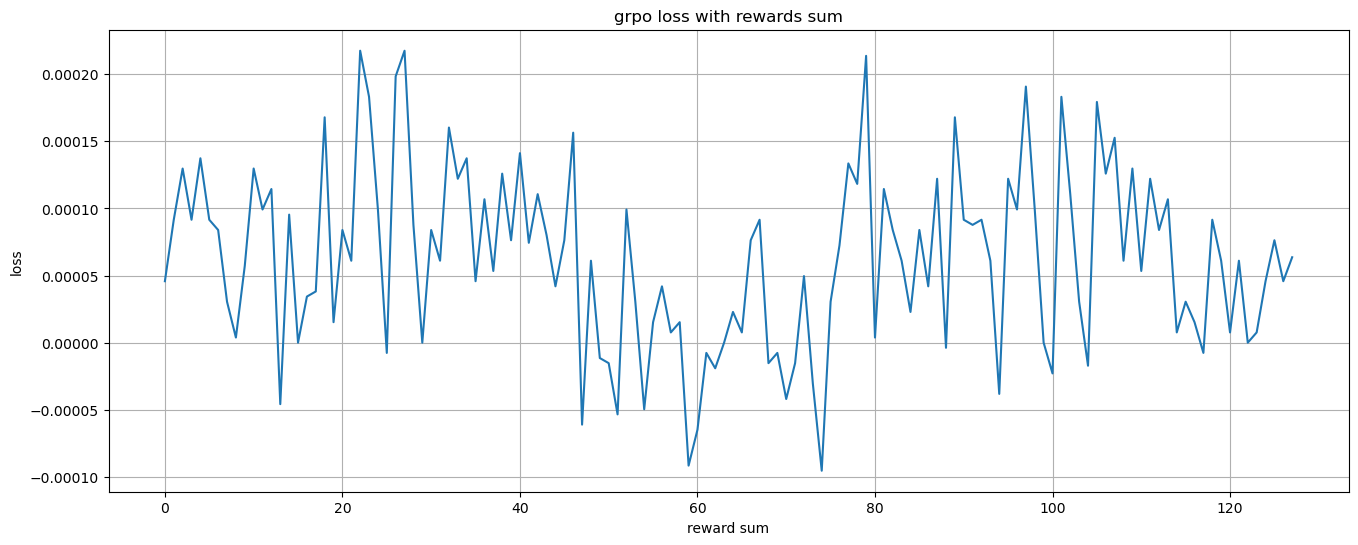

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))  
plt.plot(loss_list)
plt.title('grpo loss with rewards sum')
plt.xlabel('reward sum')
plt.ylabel('loss')
plt.grid()
plt.show()